In [1]:
from google.colab import drive
from IPython.display import Markdown, display
import pandas as pd
import numpy as np

try:
  drive.mount('/content/gdrive')
  pathBase="/content/gdrive/MyDrive/Research/Sinhala NLP/ACL 2024/Shoulders-of-Giants/"
except:
  print("Load the drive manually from the left panel first. Then run this again,")
  pathBase="/content/drive/MyDrive/Research/Sinhala NLP/ACL 2024/Shoulders-of-Giants/"

outputPath=pathBase+"outputs/"


Mounted at /content/gdrive


In [2]:
classes=[i for i in range(6)]
data={}
fullDF=pd.DataFrame()

for i in classes:
  data[i]=pd.read_csv(pathBase+"acl 2024 data - class"+str(i)+".csv", thousands=',')
  data[i]=data[i].loc[data[i]["Keeping"] == "Y"]
  data[i]=data[i].loc[(data[i]["data released?-Choice"] != "NOT applicable") | (data[i]["code released?-Choice"] != "NOT applicable")| (data[i]["model released?-Choice"] != "NOT applicable")| (data[i]["tool released?-Choice"] != "NOT applicable")]
  data[i] = data[i][data[i]['paper ID'].notna()]
  data[i][["language"]]=data[i][["language"]].fillna(method='ffill')
  data[i]["Class"]=i
  fullDF = pd.concat([fullDF, data[i]], ignore_index=True)


In [3]:
MiscDF={}

for i in data:
  m=data[i][["language","paper ID","nlp/cl task 1","nlp/cl task 2"]]
  m = m.loc[m["nlp/cl task 1"] == "Misc"]
  MiscDF[i]=m

In [4]:
nanDF=pd.DataFrame()

for i in data:
  nn=MiscDF[i]
  nn = nn.loc[nn["nlp/cl task 2"].isna()]
  nanDF = pd.concat([nanDF, nn], ignore_index=True)

In [5]:
MiscDF=fullDF.loc[fullDF["nlp/cl task 1"] == "Misc"][["Class","language","paper ID","nlp/cl task 2"]]

MiscDF.to_csv(outputPath+"MISC.csv")


In [6]:
fullDF["nlp/cl tasks"]=0
fullDF["nlp/cl tasks"]=fullDF["nlp/cl tasks"].astype('object')

# Define a custom function to combine columns
def combine_columns(row):
  tasks=[row['nlp/cl task 1']]
  if isinstance(row['nlp/cl task 2'], str):
    tasks.append(row['nlp/cl task 2'])
  if isinstance(row['nlp/cl task 3'], str):
    tasks.append(row['nlp/cl task 3'])
  return tasks

# Apply the custom function to create a new column 'Combined'
fullDF["nlp/cl tasks"] = fullDF.loc[fullDF["nlp/cl task 1"] != "Misc"].apply(combine_columns, axis=1)

In [7]:
# importing the module
import json

# reading the data from the file
with open(pathBase+'miscMap.txt') as f:
    miscReplacement = f.read()

# reconstructing the data as a dictionary
miscReplacement = json.loads(miscReplacement)

In [8]:
fullMlist=set(fullDF.loc[fullDF["nlp/cl task 1"] == "Misc"]["nlp/cl task 2"].tolist()+MiscDF.loc[MiscDF["Class"] == 0]["nlp/cl task 2"].tolist())

for fm in fullMlist:
  if fm not in miscReplacement and fm not in miscReplacement.values():
    print(fm)

A drag and drop NLP suite! 


In [9]:
for m in miscReplacement:
  fullDF.loc[fullDF["nlp/cl task 2"] == m, "nlp/cl tasks"] = miscReplacement[m]

def miscListing(row):
  tasks=[]
  if type(row['nlp/cl tasks'])=='str':
    tasks.append(row['nlp/cl tasks'])
  else:
    tasks=row['nlp/cl tasks']
  return tasks

fullDF["nlp/cl tasks"] =fullDF.apply(miscListing, axis=1)


drawDf=fullDF[["Class","language","nlp/cl tasks"]]

In [10]:
drawDf.to_csv(outputPath+"drawDf.csv")

In [11]:
for m in miscReplacement:
  fullDF.loc[fullDF["nlp/cl task 2"] == m, "nlp/cl task 2"] = miscReplacement[m]

TaskDF=fullDF[["Class","language","nlp/cl task 1"]].dropna().rename(columns={"nlp/cl task 1": "nlp/cl tasks"})
TaskDF = pd.concat([TaskDF, fullDF[["Class","language","nlp/cl task 2"]].dropna().rename(columns={"nlp/cl task 2": "nlp/cl tasks"})], ignore_index=True)
TaskDF = pd.concat([TaskDF,fullDF[["Class","language","nlp/cl task 3"]].dropna().rename(columns={"nlp/cl task 3": "nlp/cl tasks"})], ignore_index=True)

TaskDF=TaskDF.loc[TaskDF["nlp/cl tasks"] != "Misc"]

In [12]:
TaskDF=TaskDF.groupby(['Class', 'nlp/cl tasks']).size().reset_index(name='counts')

In [13]:
with open(pathBase+"validTasks.txt") as f:
    validTasks = f.read().splitlines()

In [14]:
def isValidTask(row):
  if row['nlp/cl tasks'] not in validTasks:
    row['nlp/cl tasks']=np.nan
  return(row)

TaskDF=TaskDF.apply(isValidTask, axis=1).dropna()

In [15]:
TransTaskDF=pd.DataFrame()

for i in classes:
  sliceDF=TaskDF[TaskDF["Class"]==i]
  sliceDF=sliceDF.transpose()
  sliceDF.columns = sliceDF.iloc[1]
  sliceDF.drop(sliceDF.iloc[1].name,  inplace=True)
  sliceDF.drop(sliceDF.iloc[0].name,  inplace=True)
  TransTaskDF = pd.concat([TransTaskDF,sliceDF], ignore_index=True)

TransTaskDF=TransTaskDF.transpose().fillna(0).sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort', na_position='last', sort_remaining=True, ignore_index=False, key=None)

TransTaskDF.index=TransTaskDF.index.str.title()

TransTaskDF['Total'] = TransTaskDF.sum(axis=1, numeric_only=True)

TransTaskDF=TransTaskDF.sort_values('Total', ascending=False)

for i in classes:
  TransTaskDF.at['Total', i] = TransTaskDF[i].sum()

TransTaskDF.at['Total', 'Total'] = TransTaskDF['Total'].sum()

TransTaskDF = TransTaskDF.astype('int64')

TransTaskDF.to_csv(outputPath+"TaskDF.csv")

In [16]:
TaskDFlatex=TransTaskDF.to_latex()

TaskDFlatex=TaskDFlatex.split("\midrule")[1]
TaskDFlatex=TaskDFlatex.split("\\bottomrule")[0].split("\\bottomrule")[0]
while "&  " in TaskDFlatex:
  TaskDFlatex=TaskDFlatex.replace("&  ","& ")
while "  &" in TaskDFlatex:
  TaskDFlatex=TaskDFlatex.replace("  &"," &")

replacements={
    "Asr":"Automatic Speech Recognition (ASR)",
    "Bli":"Bilingual Lexicon Induction (BLI)",
    "Coreference":"Coreference Resolution",
    "Cross-Lingual":"Cross-Lingual Applications",
    "Discorse":"Discourse Analysis",
    "Ie":"Information Extraction",
    "Langid":"Language Identification (LangID)",
    "Ner":"Named-Entity Recognition (NER)",
    "Nlp Tools":"NLP Tools",
    "News/Sm Reccomendation":"News/Social Media Recommendation",
    "Ocr":"Optical Character Recognition (OCR)",
    "Pos":"Part of Speech (PoS)",
    "Qna":"Question and Answer (QnA)",
    "Spelling And Grammar":"Spelling and Grammar",
    "Text-To-Speech":"Text-to-Speech",
    "Inference":"Lexical Inference",
    "Mis-Info Detection":"Misinformation Detection",

    "Total &":"\hline\n\\textbf{Total} &"
    }

for r in replacements:
  TaskDFlatex=TaskDFlatex.replace(r,replacements[r])

TaskDFlatex=TaskDFlatex[1:-3]

f=open(outputPath+"TaskDF.tex",'w')
f.write(TaskDFlatex)
f.close()

In [17]:
sourceList=["data released?","code released?","model released?","tool released?"]

wherDF=fullDF[["Class","language"]+sourceList]
wherDF=wherDF.fillna(0)

sourceListRename={s:s.split(" ")[0] for s in sourceList}
wherDF=wherDF.rename(columns=sourceListRename)
sourceList=[sourceListRename[s] for s in sourceList]


dataSources={
    'github':'GitHub',
    'huggingface':'Hugging Face',
    'bitbucket':'Bitbucket',
    'gitlab':'GitLab',
    'drive.google':'Google Drive',
    'zenodo':'Zenodo',
    'sf.net':'SourceForge',
    'sourceforge':'SourceForge',
    'mendeley':'Mendeley',
    'dropbox':'Dropbox',
    'codeberg':'Codeberg',

# Other places
    '://':'Other',
    'bit.ly':'Other',
    'Contact':'Other',
     '.org':'Other',
    'ortolang.fr':'Other',
}

for s in sourceList:
  for d in dataSources:
    wherDF.loc[wherDF[s].str.contains(d, na=False), s] = dataSources[d]
  #wherDF.loc[wherDF[s].str.contains('.', na=False), s] = 'Other'  # To catch other malformed URLs


wherDF.to_csv(outputPath+"wherDF.csv")

In [18]:
wherDFnew={}

for i in classes:
  wherDFslice=wherDF[wherDF['Class']==i]
  wherDFnew[i]={}
  for j in sourceList:
    wherDFnewCube=wherDFslice[['Class',j]]
    wherDFnewCube=wherDFnewCube.groupby(['Class',j]).size().reset_index(name='counts')
    wherDFnewCube=wherDFnewCube.transpose()
    wherDFnewCube.columns = wherDFnewCube.iloc[1]
    wherDFnewCube.drop(wherDFnewCube.iloc[1].name,  inplace=True)
    wherDFnewCube.drop(wherDFnewCube.iloc[0].name,  inplace=True)
    wherDFnewCube.at['counts','Class'] = i
    wherDFnewCube=wherDFnewCube.set_index('Class')
    wherDFnewCube = wherDFnewCube.drop([0], axis=1)
    wherDFnew[i][j]=wherDFnewCube


wherDF={}

for j in sourceList:
  wherDF[j]=pd.DataFrame()
  for i in classes:
    wherDF[j] = pd.concat([wherDF[j],wherDFnew[i][j]], ignore_index=True)
  wherDF[j]=wherDF[j].fillna(0)

In [19]:
set(dataSources.values())

{'Bitbucket',
 'Codeberg',
 'Dropbox',
 'GitHub',
 'GitLab',
 'Google Drive',
 'Hugging Face',
 'Mendeley',
 'Other',
 'SourceForge',
 'Zenodo'}

In [20]:
for s in sourceList:
  wherDFNorm=wherDF[s]
  wherDFNormCols=wherDFNorm.columns.tolist()
  wherDFNorm["Sum"]=wherDFNorm.sum(axis=1)
  wherDF[s]=wherDFNorm

In [21]:
wherDF[sourceList[0]]


data,GitHub,Google Drive,Hugging Face,Other,Zenodo,Codeberg,Mendeley,Dropbox,GitLab,Sum
0,29,1,1,7,2,0,0,0,0,40
1,18,0,1,10,2,0,0,0,0,31
2,29,1,1,12,1,1,1,0,0,46
3,45,1,1,6,2,0,0,1,1,57
4,36,1,1,11,2,0,0,0,0,51
5,31,1,1,12,1,0,0,0,1,47


In [22]:
wherDF[sourceList[1]]

code,Bitbucket,GitHub,GitLab,Other,Codeberg,Zenodo,Sum
0,3,23,1,1,0,0,28
1,1,15,0,3,0,0,19
2,0,27,0,0,1,1,29
3,0,20,0,0,0,0,20
4,0,25,1,0,0,0,26
5,0,43,1,1,0,0,45


In [23]:
wherDF[sourceList[2]]

model,GitHub,Google Drive,Hugging Face,Other,Zenodo,Sum
0,2,1,2,0,0,5
1,1,0,0,3,0,4
2,3,0,5,0,1,9
3,1,1,1,0,0,3
4,0,0,2,1,0,3
5,10,1,1,2,0,14


In [24]:
wherDF[sourceList[3]]

tool,Bitbucket,Hugging Face,Other,GitHub,Google Drive,Sum
0,1,1,10,0,0,12
1,0,1,18,2,0,21
2,0,0,4,1,0,5
3,0,0,7,5,1,13
4,0,0,3,2,0,5
5,0,0,2,2,0,4


In [25]:
baseSums={}

for i in sourceList:
  d=wherDF[i].sum().to_dict()
  for s in d:
    if s in baseSums:
      baseSums[s]=baseSums[s]+d[s]
    else:
      baseSums[s]=d[s]


baseSums = sorted(baseSums.items(), key=lambda x:x[1])[:-1]
baseSums.reverse()

baseSums=[k   for k,v in baseSums]
baseSums.remove("Other")
baseSums.append("Other")
baseSums.append("Sum")

baseSums

['GitHub',
 'Hugging Face',
 'Zenodo',
 'Google Drive',
 'Bitbucket',
 'GitLab',
 'Codeberg',
 'Dropbox',
 'Mendeley',
 'Other',
 'Sum']

In [26]:
for i in sourceList:
  curentL=list(wherDF[i].columns)
  for b in baseSums:
    if b not in curentL:
      wherDF[i][b]=0

  wherDF[i]=wherDF[i][baseSums]


wherDF[sourceList[0]]

data,GitHub,Hugging Face,Zenodo,Google Drive,Bitbucket,GitLab,Codeberg,Dropbox,Mendeley,Other,Sum
0,29,1,2,1,0,0,0,0,0,7,40
1,18,1,2,0,0,0,0,0,0,10,31
2,29,1,1,1,0,0,1,0,1,12,46
3,45,1,2,1,0,1,0,1,0,6,57
4,36,1,2,1,0,0,0,0,0,11,51
5,31,1,1,1,0,1,0,0,0,12,47


In [27]:
import matplotlib.pyplot as plt

def drawGraph(df,fileName,ylabel,showAxis):
  dd=df.to_dict()
  sources=df.columns.tolist()[:-1]
  bottom=[0] * len(sources)
  width=0.9
  fileName="Links_"+fileName

  fig, ax = plt.subplots(figsize=(6, 4.5), dpi=100)

  for c in sources:
    vals=list(dd[c].values())
    vals=[v/s for v,s in zip(vals,list(dd["Sum"].values()))]
    if sum(bottom)==0:
      ax.barh(classes, vals, width,  label=c)   #,color=c
    else:
      ax.barh(classes, vals,width, left=bottom, label=c)
    bottom=[sum(x) for x in zip(bottom,vals)]

  legend=ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=5)

  plt.xlabel("Class Fraction")
  plt.ylabel(ylabel)
  if(not showAxis):
    legend.remove()

  plt.savefig(outputPath+fileName+'.pdf',bbox_inches='tight', dpi=500)

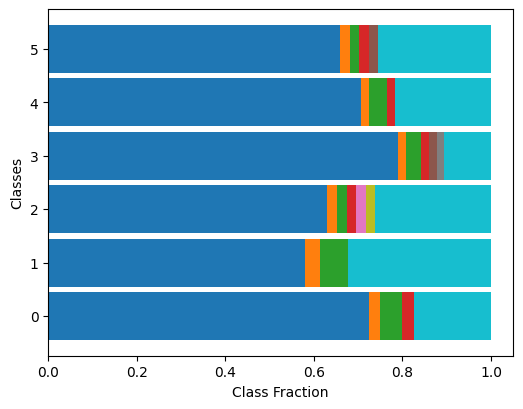

In [28]:
drawGraph(wherDF[sourceList[0]],"Data","Classes",False)

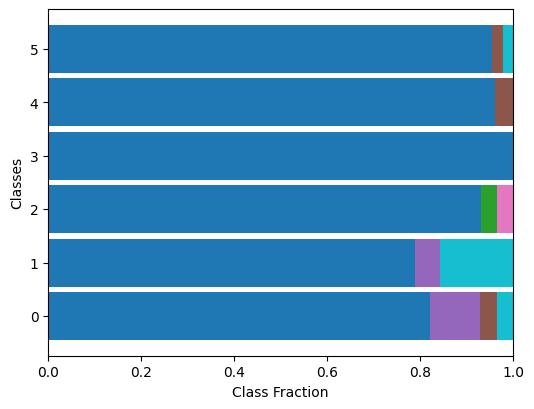

In [29]:
drawGraph(wherDF[sourceList[1]],"Code","Classes",False)

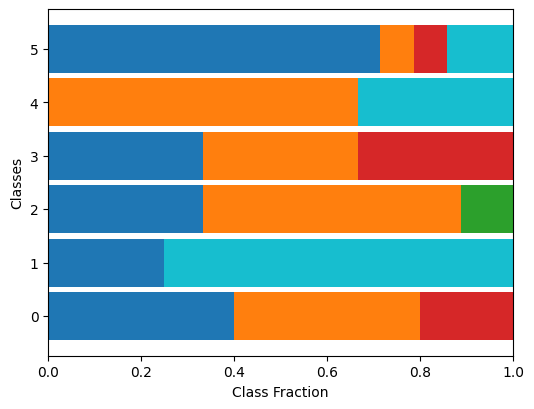

In [30]:
drawGraph(wherDF[sourceList[2]],"Model","Classes",False)

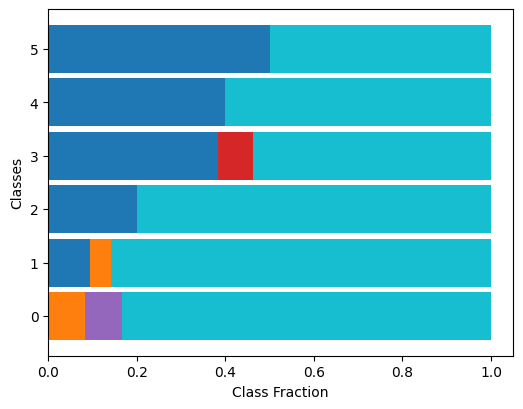

In [31]:
drawGraph(wherDF[sourceList[3]],"Tools","Classes",False)

In [32]:
wherDF[sourceList[0]].columns.to_list()[:-1]

['GitHub',
 'Hugging Face',
 'Zenodo',
 'Google Drive',
 'Bitbucket',
 'GitLab',
 'Codeberg',
 'Dropbox',
 'Mendeley',
 'Other']

In [33]:
wherDFCumil=pd.DataFrame()

for i in sourceList:
  w=wherDF[i]
  w["Task"]=w.columns.name.capitalize()
  wherDFCumil = pd.concat([wherDFCumil,w], ignore_index=True)

wherDFCumil=wherDFCumil.groupby(['Task']).sum()

for i in wherDFCumil.columns.to_list()[:-1]:
  wherDFCumil.at['Total', i] = wherDFCumil[i].sum()

wherDFCumil=wherDFCumil.reset_index().rename(columns={'Sum':'Total'})
wherDFCumil=wherDFCumil.set_index('Task')

wherDFCumil.at['Total', 'Total'] = wherDFCumil['Total'].sum()

wherDFCumil=wherDFCumil.transpose()
wherDFCumil = wherDFCumil.astype('int64')

<ipython-input-33-4ea5f4317288>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["Task"]=w.columns.name.capitalize()
<ipython-input-33-4ea5f4317288>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w["Task"]=w.columns.name.capitalize()
<ipython-input-33-4ea5f4317288>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [34]:
wherDFlatex=wherDFCumil.to_latex()

wherDFlatex=wherDFlatex.split("\midrule")[1]
wherDFlatex=wherDFlatex.split("\\bottomrule")[0].split("\\bottomrule")[0]
while "&  " in wherDFlatex:
  wherDFlatex=wherDFlatex.replace("&  ","& ")
while "  &" in wherDFlatex:
  wherDFlatex=wherDFlatex.replace("  &"," &")


wherDFlatex=wherDFlatex[1:-3].replace("Total &","\hline\n\\textbf{Total} &")

f=open(outputPath+"wherDFCumil.tex",'w')
f.write(wherDFlatex)
f.close()

In [35]:
cantDF=fullDF.loc[(fullDF["data released?-Choice"] == "cant release") | (fullDF["code released?-Choice"] == "cant release")| (fullDF["model released?-Choice"] == "cant release")| (fullDF["tool released?-Choice"] == "cant reease")]

cantDF

,language,paper ID,data released?,data released?-Choice,code released?,code released?-Choice,model released?,model released?-Choice,tool released?,tool released?-Choice,nlp/cl task 1,nlp/cl task 2,nlp/cl task 3,Keeping,Class,Unnamed: 14,Unnamed: 13,Unnamed: 15,Category covered in Paper,nlp/cl tasks
69,Cherokee,2021.acl-demo.33,https://github.com/ZhangShiyue/ChrEn,y,https://github.com/ZhangShiyue/ChrEnTranslate,y,NaN,NOT applicable,https://chren.cs.unc.edu/,cant reease,Translation,NaN,NaN,Y,1,NaN,NaN,NaN,NaN,[Translation]
191,Udmurt,W18-0203,NaN,cant release,NaN,NOT applicable,NaN,NOT applicable,NaN,NOT applicable,Corpora,NaN,NaN,Y,2,NaN,NaN,NaN,NaN,[Corpora]
283,Basque,2022.eamt-1.6,NaN,cant release,https://gitlab.com/xabiersoto1/bt_tagging_and_...,y,NaN,NOT applicable,NaN,NOT applicable,Translation,NaN,NaN,Y,4,NaN,NaN,NaN,NaN,[Translation]
285,catalan,2021.mrl-1.4,NaN,cant release,NaN,NOT applicable,NaN,NOT applicable,NaN,NOT applicable,BLI,NaN,NaN,Y,4,NaN,NaN,NaN,NaN,[BLI]
329,korean,2021.mtsummit-up.5,NaN,NOT applicable,NaN,cant release,NaN,cant release,NaN,NOT applicable,Translation,NaN,NaN,Y,4,NaN,NaN,0.0,NaN,[Translation]
